In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
# warnings.filterwarnings('default')

sns.set_style("darkgrid")

df = pd.read_csv('https://raw.githubusercontent.com/jugalm/News_Stocks/master/data/weekly_gti_stock_price.csv')

df = df.dropna()
del df['Unnamed: 0']

# Classifying 

- Greater than +1 Std Deviation as 1
- Within +- 1 Standard deviation as 0
- Less than -1 Std Deviationa as -1 

In [2]:
upper = df.excess_percent_change.mean() + df.excess_percent_change.std()
lower = df.excess_percent_change.mean() - df.excess_percent_change.std()

df.loc[(df.excess_percent_change > lower) &(df.excess_percent_change > lower),'3_category'] =  0
df.loc[(df.excess_percent_change >= upper),'3_category'] =  1
df.loc[(df.excess_percent_change <= lower),'3_category'] =  -1


# Reposne variable is the one defined above

# Feautures are the 4 lag standarized GT Index and 4 lag standarized weekly volume

In [3]:
X_1 =df[['adjusted_gt_index_lag1',  'adjusted_gt_index_lag2', 'adjusted_gt_index_lag3', 'adjusted_gt_index_lag4', 
       'standarized_weekly_volume', 'standarized_weekly_volume_lag1',
       'standarized_weekly_volume_lag2', 'standarized_weekly_volume_lag3']]

y_1 =df['3_category']

X_train, X_test, y_train, y_test = train_test_split(X_1, y_1, test_size=0.20)

# SVM 

In [4]:
clf = svm.SVC()
clf.fit(X_train, y_train)

y_fit = clf.predict(X_test)
print(classification_report(y_test, y_fit))
print(confusion_matrix(y_test, y_fit))

             precision    recall  f1-score   support

       -1.0       0.38      0.08      0.13        73
        0.0       0.78      0.99      0.87       462
        1.0       1.00      0.02      0.03        65

avg / total       0.76      0.77      0.69       600

[[  6  67   0]
 [  5 457   0]
 [  5  59   1]]


# Neural Network

In [5]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(15, 2))
clf.fit(X_train, y_train) 

y_fit = clf.predict(X_test)
print(classification_report(y_test, y_fit))
print(confusion_matrix(y_test, y_fit))

             precision    recall  f1-score   support

       -1.0       0.23      0.14      0.17        73
        0.0       0.79      0.95      0.86       462
        1.0       0.00      0.00      0.00        65

avg / total       0.64      0.75      0.69       600

[[ 10  63   0]
 [ 22 439   1]
 [ 12  53   0]]


# Random Forest


In [6]:
clf = RandomForestClassifier(n_estimators=100, max_depth=2)
clf.fit(X_train, y_train) 

y_fit = clf.predict(X_test)
print(classification_report(y_test, y_fit))
print(confusion_matrix(y_test, y_fit))

             precision    recall  f1-score   support

       -1.0       0.00      0.00      0.00        73
        0.0       0.77      1.00      0.87       462
        1.0       0.00      0.00      0.00        65

avg / total       0.59      0.77      0.67       600

[[  0  73   0]
 [  0 462   0]
 [  0  65   0]]


# Functions needed to run n simulation with different training and test sample

In [7]:
from collections import defaultdict

def report2dict(cr):
    # Parse rows
    tmp = list()
    for row in cr.split("\n"):
        parsed_row = [x for x in row.split("  ") if len(x) > 0]
        if len(parsed_row) > 0:
            tmp.append(parsed_row)
    
    # Store in dictionary
    measures = tmp[0]

    D_class_data = defaultdict(dict)
    for row in tmp[1:]:
        class_label = row[0]
        for j, m in enumerate(measures):
            D_class_data[class_label][m.strip()] = float(row[j + 1].strip())
    return D_class_data

In [8]:
def run_simulation(n, x, y, test_portion, method):
    result = []
    
    for i in range(n):
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_portion)
        
        if method == 'SVM':
            clf = svm.SVC()
        elif method == 'Neural Network':
            clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(15, 2)) 
        elif method == 'Random Forest':
            clf = RandomForestClassifier(n_estimators=100, max_depth=2)

        clf.fit(X_train, y_train)
        
        y_fit = clf.predict(X_test)
        res = pd.DataFrame(report2dict(classification_report(y_test, y_fit)))
        result.append(res.loc['precision', 'avg / total'])
        
    return result

# SVM 100 simulation Result

Average accuracy of prediction: 0.7069000000000001


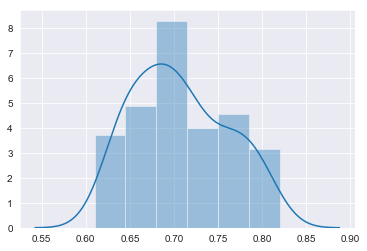

In [9]:
res = run_simulation(100, X_1, y_1, 0.20, 'SVM')

print("Average accuracy of prediction: " + str(np.array(res).mean()))

sns.distplot(res)

# Neural Network 100 simulation Result

Average accuracy of prediction: 0.6798000000000001


100

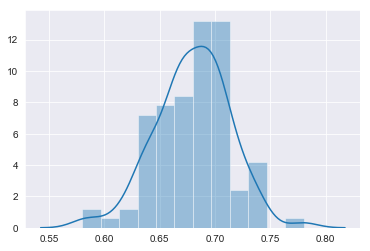

In [10]:
res = run_simulation(100, X_1, y_1, 0.20, 'Neural Network')

print("Average accuracy of prediction: " + str(np.array(res).mean()))

sns.distplot(res)
len(res)

# Random Forest 100 simulation Result

Average accuracy of prediction: 0.611


100

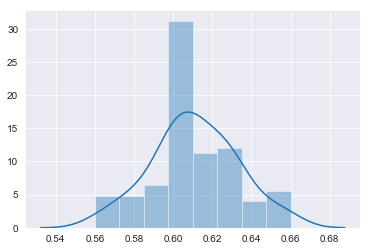

In [11]:
res = run_simulation(100, X_1, y_1, 0.20, 'Random Forest')

print("Average accuracy of prediction: " + str(np.array(res).mean()))

sns.distplot(res)
len(res)